In [17]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [2]:
DATA_PATH = r"C:\Users\eatb6\Documents\ML\Final Project\ML2021BigProject-main\ML2021BigProject-main\Code\data_10.json"


In [3]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [4]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [18]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [102]:
def build_model(hp):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(hp.Int("input_units", 32, 256, 32), (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(hp.Int("input2_units", 32, 256, 32), (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
   
    #3rd conv layer
    #model.add(keras.layers.Conv2D(hp.Int("input3_units", 32, 256, 32), (2, 2), activation='relu'))
    #model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    #model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    #model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    #model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    #model.add(keras.layers.BatchNormalization())

    

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    #model.add(keras.layers.Dense(32, activation='relu'))
    #model.add(keras.layers.Dropout(0.1))
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [95]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


In [103]:
 X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.2)

# create network
#input_shape = (X_train.shape[1], X_train.shape[2], 1)
#model = build_model(hp)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 256)      2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 256)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 256)        1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 3968)              0

In [97]:
import time
LOG_DIR = f"{int(time.time())}"

In [98]:
tuner=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,
                          directory=LOG_DIR,project_name="MusicClass")


In [99]:
tuner.search(x=X_train,
            y=y_train,
            epochs=8,
            batch_size=64,
            validation_data=(X_test,y_test))

Trial 3 Complete [00h 07m 16s]
val_accuracy: 0.7310000061988831

Best val_accuracy So Far: 0.7310000061988831
Total elapsed time: 00h 14m 10s
INFO:tensorflow:Oracle triggered exit


In [100]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 256)      2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 256)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 256)        1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 64)         147520    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 3968)              0

Epoch 1/15
200/200 [==============================] - 57s 276ms/step - loss: 0.7527 - accuracy: 0.7370 - val_loss: 0.8200 - val_accuracy: 0.7144
Epoch 2/15
200/200 [==============================] - 55s 274ms/step - loss: 0.6888 - accuracy: 0.7622 - val_loss: 0.9597 - val_accuracy: 0.6781
Epoch 3/15
200/200 [==============================] - 55s 277ms/step - loss: 0.6070 - accuracy: 0.7957 - val_loss: 0.8505 - val_accuracy: 0.7125
Epoch 4/15
200/200 [==============================] - 56s 282ms/step - loss: 0.5529 - accuracy: 0.8107 - val_loss: 0.7473 - val_accuracy: 0.7425
Epoch 5/15
200/200 [==============================] - 55s 274ms/step - loss: 0.5146 - accuracy: 0.8263 - val_loss: 0.7569 - val_accuracy: 0.7538
Epoch 6/15
200/200 [==============================] - 55s 275ms/step - loss: 0.4686 - accuracy: 0.8440 - val_loss: 0.7586 - val_accuracy: 0.7381
Epoch 7/15
200/200 [==============================] - 55s 274ms/step - loss: 0.4405 - accuracy: 0.8515 - val_loss: 0.7321 - val_ac

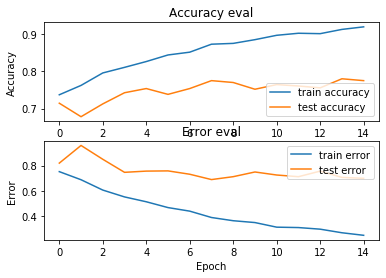

63/63 - 5s - loss: 0.6749 - accuracy: 0.7885

Test accuracy: 0.7885000109672546


In [101]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=15)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
tuner_search.search()

In [53]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


cm = confusion_matrix(preds, y_orig)

NameError: name 'preds' is not defined